## Agent 2: Executor

Agent responsible for execute the given instructions

In [ ]:
import os
import json
import time
from typing import Annotated, Sequence, List

from pydantic import BaseModel
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, TimeoutException

from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage
from langchain_openai import AzureChatOpenAI
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from typing import TypedDict, List, Optional
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import os
import faiss
import numpy as np
from openai import OpenAI

In [348]:
# Load environment variables from .env import load_env & set up OpenAI client
load_dotenv()

True

In [349]:
# Define structure for HTML element's attributes
class HTMLElementAttribute(TypedDict):
    attribute_name: str
    attribute_value: Optional[str]

# Define structure for HTML elements
class HTMLElement(TypedDict):
    html_element_id: int
    html_element_type: str
    html_attribute : List[HTMLElementAttribute]

class ExecuterAgentState(BaseModel):
    app_url: str
    html_elements: List[HTMLElement]
    execution_step: str
    previous_steps: Optional[str] = None
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [ ]:
@tool(name_or_callable="navigate_to_web_page", description="Navigate to a specified web page URL.")
def navigate_to_web_page(url: str) -> str:
    try:
        driver.get(url)
        return f"Navigated to {url} successfully."
    except Exception as e:
        return f"Failed to navigate to {url}. Error: {str(e)}"

@tool(name_or_callable="check_element_visibility", description="Check if an element is available on the web page by its ID.")
def check_element_visibility(element_id: str) -> str:
    try:
        element = driver.find_element(By.ID, element_id)
        return f"Element with ID '{element_id}' is visible." if element.is_displayed() else f"Element with ID '{element_id}' is not visible."
    except NoSuchElementException:
        return f"Element with ID '{element_id}' not found."
    except Exception as e:
        return f"Exception: {str(e)}"

@tool(name_or_callable="insert_text_by_id", description="Insert text into an input field using the element's ID.")
def insert_value(element_id: str, input_text: str) -> str:
    try:
        element = driver.find_element(By.ID, element_id)
        element.clear()
        element.send_keys(input_text)
        return f"Inserted '{input_text}' into input with ID '{element_id}' successfully."
    except NoSuchElementException:
        return f"Element with ID '{element_id}' not found."
    except Exception as e:
        return f"Exception: {str(e)}"

@tool(name_or_callable="clear_inserted_value", description="Clear the value entered in the input field using the element's ID.")
def clear_inserted_value(element_id: str) -> str:
    try:
        element = driver.find_element(By.ID, element_id)
        element.clear()
        return f"Cleared the value in {element_id} successfully."
    except NoSuchElementException:
        return f"Element with ID '{element_id}' not found."
    except Exception as e:
        return f"Exception: {str(e)}"

@tool(name_or_callable="check_the_input_field_content", description="Check the content of an input text or password field by its ID.")
def check_the_input_field_content(element_id: str, expected_value: str) -> str:
    try:
        value = driver.find_element(By.ID, element_id).get_attribute("value")
        return f"Field value matches expected: '{expected_value}'" if value == expected_value else f"Value '{value}' does not match expected '{expected_value}'"
    except Exception as e:
        return f"Exception: {str(e)}"

@tool(name_or_callable="click_element_by_class", description="Click a button or clickable element by its class.")
def click_button_by_class(class_name: str) -> str:
    try:
        button = driver.find_element(By.CLASS_NAME, class_name)
        button.click()
        return f"Clicked button with class '{class_name}' successfully."
    except Exception as e:
        return f"Exception: {str(e)}"
    
@tool(name_or_callable="click_element_by_id", description="Click a button or clickable element by its ID.")
def click_button_by_id(element_id: str) -> str:
    try:
        button = driver.find_element(By.ID, element_id)
        button.click()
        return f"Clicked button with ID '{element_id}' successfully."
    except Exception as e:
        return f"Exception: {str(e)}"

@tool(name_or_callable="check_popup_alert_message", description="Check that the popup/alert message appears and verify its content.")
def check_popup_alert_message() -> str:
    try:
        WebDriverWait(driver, 10).until(EC.alert_is_present())
        alert = driver.switch_to.alert
        message_content = alert.text
        alert.accept()
        return f"Popup displayed with message: '{message_content}'"
    except TimeoutException:
        return "No popup alert appeared within timeout."
    except Exception as e:
        return f"Exception: {str(e)}"

@tool(name_or_callable="click_popup_alert_button", description="Click the popup alert accept button.")
def click_popup_alert_button() -> str:
    try:
        WebDriverWait(driver, 10).until(EC.alert_is_present())
        alert = driver.switch_to.alert
        alert.accept()
        return "Popup alert closed successfully."
    except Exception as e:
        return f"Exception: {str(e)}"

@tool(name_or_callable="check_required_field_validation_popup_alert", description="Check if required field validation appears as a popup alert.")
def check_required_field_validation_popup_alert(input_field_id: str) -> str:
    try:
        time.sleep(10)
        active_element = driver.switch_to.active_element
        return (
            f"{input_field_id} Required tooltip triggered: Validation failed."
            if active_element.get_attribute("id") == input_field_id
            else f"{input_field_id} Required tooltip triggered: Validation passed."
        )
    except Exception as e:
        return f"Exception: {str(e)}"

tools = [
    insert_value,
    click_button_by_id,
    click_button_by_class,
    check_required_field_validation_popup_alert,
    check_popup_alert_message,
    check_the_input_field_content,
    click_popup_alert_button,
    check_element_visibility,
    clear_inserted_value,
    navigate_to_web_page
]

model = ChatOpenAI(temperature=0, openai_api_key=os.getenv("OPENAI_API_KEY"), model="gpt-4o-mini").bind_tools(tools)
modelII = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [351]:
index_stored = faiss.read_index("html_index.faiss")

with open("id_map.json", "r") as f:
    id_map = json.load(f)
    id_map = {int(k): v for k, v in id_map.items()}  # Convert keys to int

with open("element_map.json") as f:
    html_map = json.load(f)

# Embed your query
def embed_text(text):
    response = modelII.embeddings.create(
        model="text-embedding-3-small",
        input=text
    )
    return np.array(response.data[0].embedding, dtype='float32')

def identify_html_element(state: ExecuterAgentState) -> ExecuterAgentState:

    step = state.execution_step
    query_vec = embed_text(step).reshape(1, -1)
    distances, indices = index_stored.search(query_vec, 1)
    results = []

    for dist, idx in zip(distances[0], indices[0]):
        html_element_id = id_map[idx]
        results.append({
            "html_element_id": html_element_id,
            "distance": float(dist),
            "html": html_map[idx]
        })

    html = results[0]
    state.html_elements = [HTMLElement(**html["html"])]
    
    return state

In [352]:
def execute_test_cases(state: ExecuterAgentState) -> ExecuterAgentState:

    messages = [
        SystemMessage(content="""
            You are a QA agent responsible for running Selenium automation steps.
            Execute each test curent test step using the appropriate tool(s).
            You will receive one curent test step and the corresponding HTML elements from the web page.
            Previous test step(s) are provided for context.
        """),
        HumanMessage(content=json.dumps({
            "app_url": state.app_url,
            "html_elements": state.html_elements,
            "previous_test_step(s)" : state.previous_steps,
            "current_test_step": state.execution_step
        }, indent=2))
    ]
    response = model.invoke(messages)
    state.messages.append(response)

    return state

def should_continue(state: ExecuterAgentState):
    last_message = state.messages[-1]
    return "continue" if getattr(last_message, "tool_calls", None) else "end"

In [353]:
graph = StateGraph(ExecuterAgentState)

graph.add_node("identify_html_element", identify_html_element)
graph.add_node("execute_test_cases", execute_test_cases)
graph.add_node("tools", ToolNode(tools=tools))

graph.set_entry_point("identify_html_element")

graph.add_edge("identify_html_element", "execute_test_cases")
graph.add_conditional_edges("execute_test_cases", should_continue, {
    "continue": "tools",
    "end": END
})

app = graph.compile()

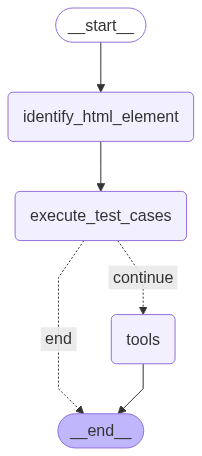

In [341]:
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
def run_agent2(driver, url: str, steps: List[str]) -> List[str]:
    results = []

    try:
        for step in steps:
            initial_state = ExecuterAgentState(
                app_url=url,
                html_elements=[],
                execution_step=step,
                messages=[]
            )
            result = app.invoke(initial_state)
            final_message = result["messages"][-1]
            results.append(final_message.content or final_message.tool_calls)
    except Exception as e:
        results.append(f"Exception while accessing {url}: {str(e)}")

    return results
